In [1]:
import numpy as np
from matplotlib import pyplot as plt

# truth
m_true = -0.9594  # slope
b_true = 4.294  # intercept
f_true = 0.534  # fractional scaling

# generate mock data
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y_true = m_true * x + b_true
y = y_true + np.abs(f_true * y_true) * np.random.randn(N)
y += yerr * np.random.randn(N)

# plot results
plt.figure(figsize=(10, 5))
plt.errorbar(x, y, yerr=yerr, fmt='ko', ecolor='red')
plt.plot(x, y_true, color='blue', lw=3)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')

Text(0,0.5,'$Y$')

In [2]:
# log-likelihood
def loglike(theta):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))

    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# prior transform
def prior_transform(utheta):
    um, ub, ulf = utheta
    m = 5.5 * um - 5.
    b = 10. * ub
    lnf = 11. * ulf - 10.

    return m, b, lnf


In [3]:
import dynesty

dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=3,
                                        bound='multi', sample='rwalk',
                                        update_interval=3.)
dsampler.run_nested()
dres = dsampler.results


iter: 23656 | batch: 10 | bound: 287 | nc: 25 | ncall: 550485 | eff(%):  4.297 | loglstar: -35.213 < -28.097 < -28.696 | logz: -39.147 +/-  0.133 | stop:  0.935                     


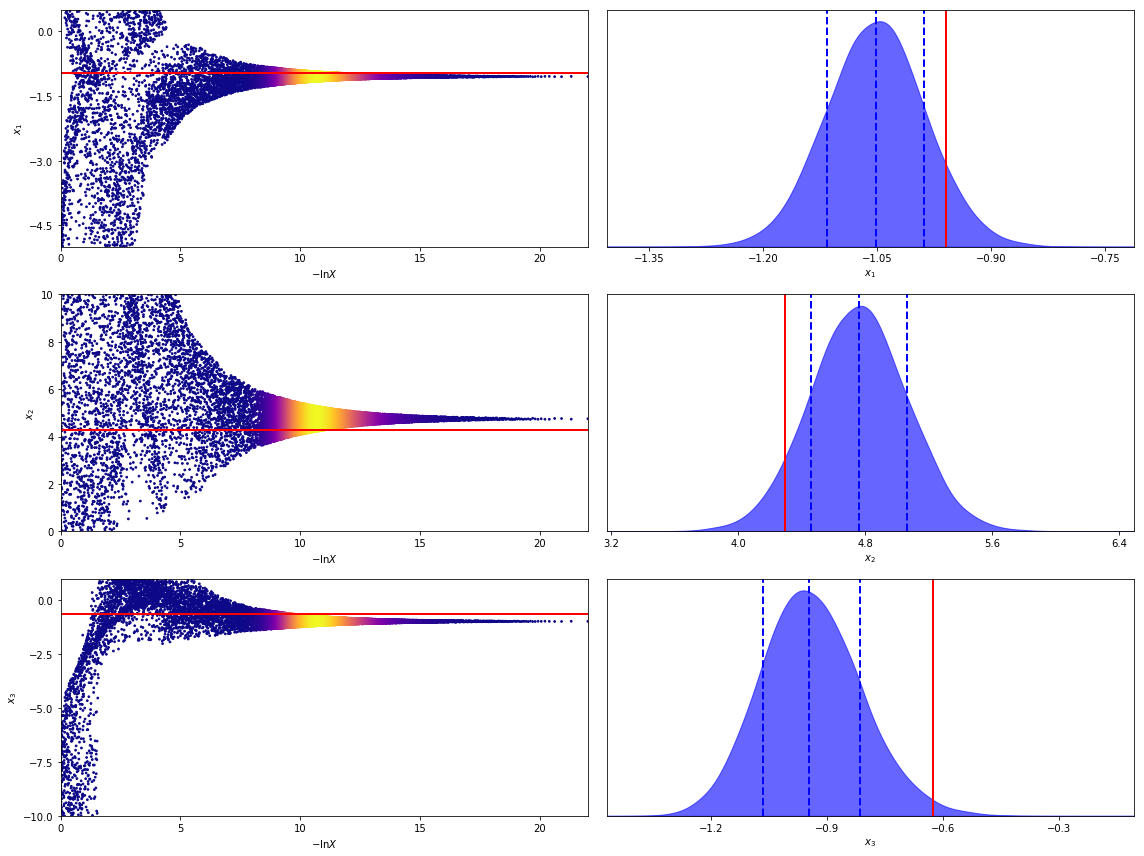

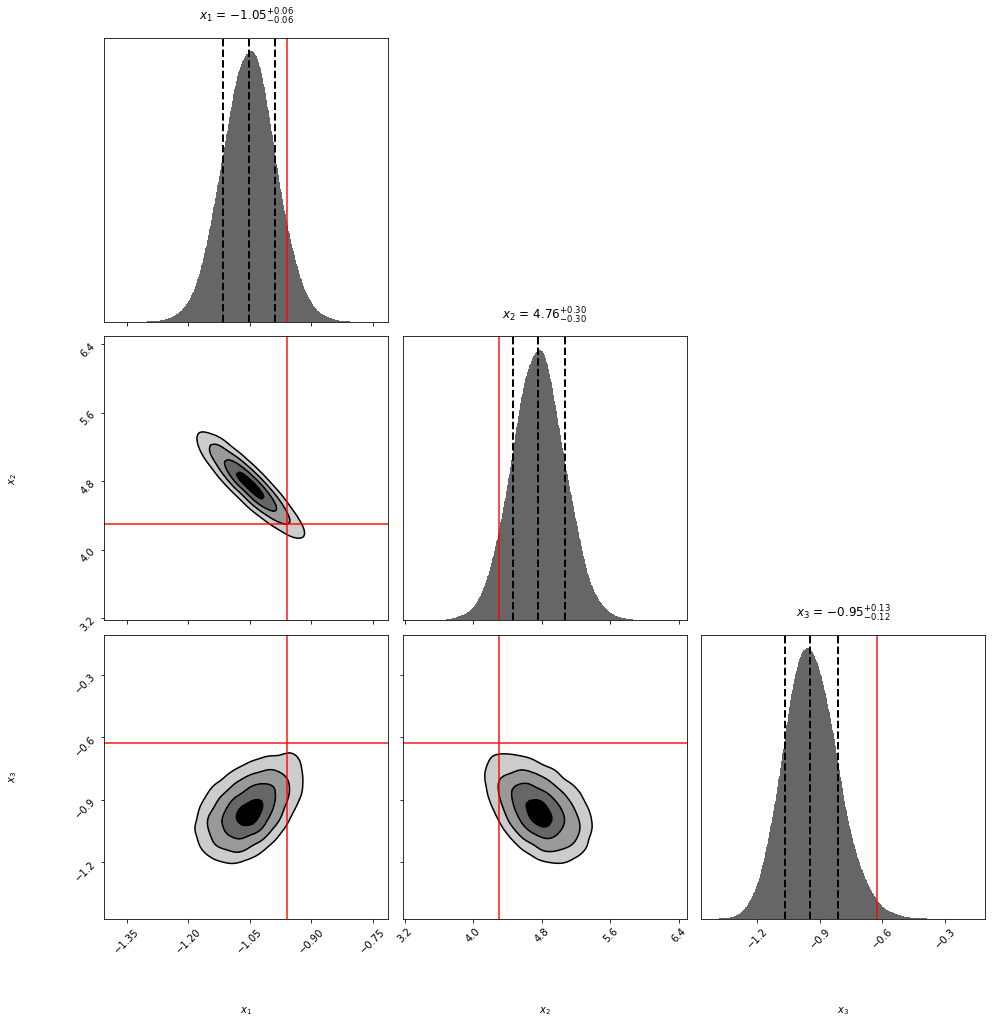

In [4]:
from dynesty import plotting as dyplot

truths = [m_true, b_true, np.log(f_true)]

# trace plot
fig, axes = dyplot.traceplot(dsampler.results, truths=truths,
                             fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

# corner plot
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True,
                              title_kwargs={'y': 1.04},
                              fig=plt.subplots(3, 3, figsize=(15, 15)))

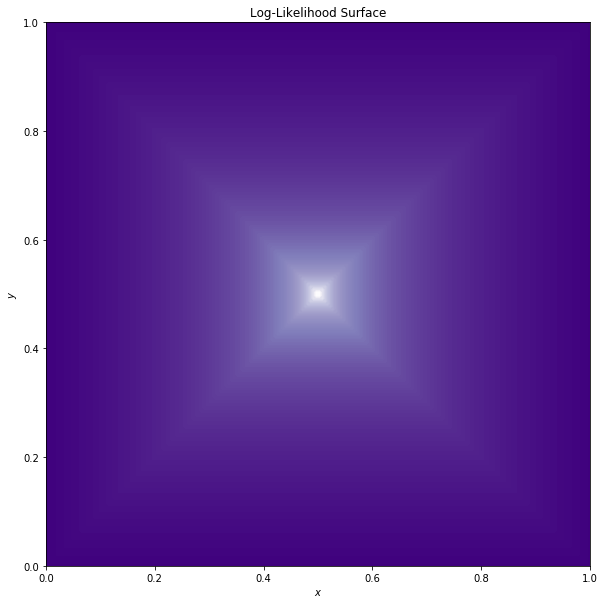

In [5]:
# define the eggbox log-likelihood
s, sigma = 100., 1.
def loglike(x):
    return -max(abs((x - 0.5) / sigma))**(1. / s)

# define the prior transform
def prior_transform(x):
    return x

# plot the log-likelihood surface
plt.figure(figsize=(10., 10.))
axes = plt.axes(aspect=1)
xx, yy = np.meshgrid(np.linspace(0., 1., 200),
                     np.linspace(0., 1., 200))
L = np.array([loglike(np.array([x, y]))
              for x, y in zip(xx.flatten(), yy.flatten())])
L = L.reshape(xx.shape)
axes.contourf(xx, yy, L, 200, cmap=plt.cm.Purples_r)
plt.title('Log-Likelihood Surface')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

In [6]:
ndim = 2
nlive = 1000
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim,
                                first_update={'min_ncall': -np.inf,
                                              'min_eff': np.inf},
                                bound='multi', sample='unif', nlive=nlive)
sampler.run_nested(dlogz=0.01, maxiter=3500, add_live=False)
res = sampler.results

iter: 3501 | bound: 9 | nc: 8 | ncall: 7661 | eff(%): 45.699 | loglstar:   -inf < -0.976 <    inf | logz: -1.020 +/-  0.006 | dlogz:  0.032 >  0.010             

/home/wolbach/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


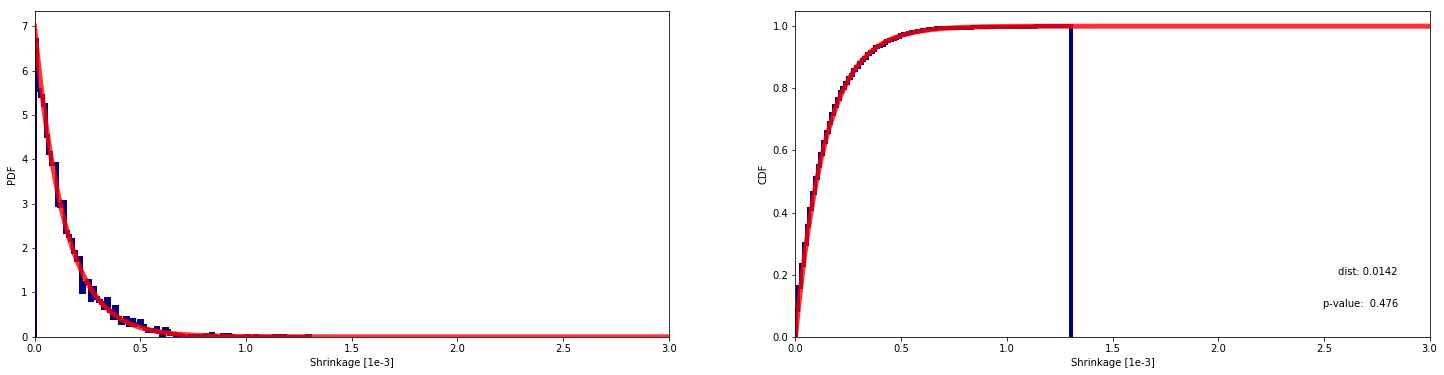

In [10]:
#different visual
from scipy.stats import kstest

vol = (2 * (-res['logl'])**s)**ndim  # compute volumes
t = vol[1:] / vol[:-1]  # compute shrinkage
S = 1 - t**(1. / ndim)  # transform shrinkage to slices

# define our PDF/CDF
def pdf(s):
    return ndim * nlive * (1. - s)**(ndim * nlive - 1.)
def cdf(s):
    return 1. - (1. - s)**(ndim * nlive)

# check whether the two distributions are consistent
k_dist, k_pval = kstest(S, cdf)  # 1-sample KS test

# plot results
xgrid = np.linspace(0., 0.01, 10000)
fig, axes = plt.subplots(1, 2, figsize=(25, 6))

# PDF
ax = axes[0]
pdfgrid = pdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=100, histtype='step', color='navy',
                  normed=True, lw=4)
ax.plot(xgrid * 1e3, pdfgrid / 1e3, color='red', alpha=0.8, lw=5)
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 3.])
ax.set_ylabel('PDF')

# CDF
ax = axes[1]
cdfgrid = cdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=100, histtype='step', cumulative=True,
                  color='navy', normed=True, lw=4)
ax.plot(xgrid * 1e3, cdfgrid, color='red', alpha=0.8, lw=5)
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 3.])
ax.set_ylabel('CDF')
ax.text(0.95, 0.2, 'dist: {:6.3}'.format(k_dist),
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)
ax.text(0.95, 0.1, 'p-value: {:6.3}'.format(k_pval),
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes);

In [11]:
#bootstrapping off
ndim = 2
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim,
                                first_update={'min_ncall': -np.inf,
                                              'min_eff': np.inf},
                                bound='multi', sample='unif', nlive=nlive,
                                bootstrap=0)
sampler.run_nested(dlogz=0.01, maxiter=3500, add_live=False)
res = sampler.results

iter: 3501 | bound: 10 | nc: 5 | ncall: 8372 | eff(%): 41.818 | loglstar:   -inf < -0.976 <    inf | logz: -1.020 +/-  0.006 | dlogz:  0.032 >  0.010            

In [12]:
#increase dimensions
ndim = 7
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim,
                                first_update={'min_ncall': -np.inf,
                                              'min_eff': np.inf},
                                bound='multi', sample='unif', nlive=nlive)
sampler.run_nested(dlogz=0.01, maxiter=3500, add_live=False)
res = sampler.results

iter: 3501 | bound: 26 | nc: 6 | ncall: 21231 | eff(%): 16.490 | loglstar:   -inf < -0.988 <    inf | logz: -1.023 +/-  0.006 | dlogz:  0.031 >  0.010             

In [13]:
# LogGamma is useful for stress testing the effectiveness of bounding distributions

from scipy.stats import loggamma, norm

# LogGamma component
def lng(x):
    lng1 = loggamma.logpdf(x[0], c=1., loc=1./3., scale=1./30.)
    lng2 = loggamma.logpdf(x[0], c=1., loc=2./3., scale=1./30.)

    return np.logaddexp(lng1, lng2) + np.log(0.5)

# Normal component
def lnn(x):
    lnn1 = norm.logpdf(x[1], loc=1./3., scale=1./30.)
    lnn2 = norm.logpdf(x[1], loc=2./3., scale=1./30.)

    return np.logaddexp(lnn1, lnn2) + np.log(0.5)

# extra-dimensional component
def lnd_i(x_i, i):
    if i >= 3:
        if i <= (ndim + 2) / 2.:
            return loggamma.logpdf(x_i, c=1., loc=2./3., scale=1./30.)
        else:
            return norm.logpdf(x_i, loc=2./3., scale=1./30.)
    else:
        return 0.
def lnd(x):
    return sum([lnd_i(x_i, i) for i, x_i in enumerate(x)])

# define the log-likelihood
def loglike(x):
    return lng(x) + lnn(x) + lnd(x)

# define the prior transform
def prior_transform(x):
    return x

/home/wolbach/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1615: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


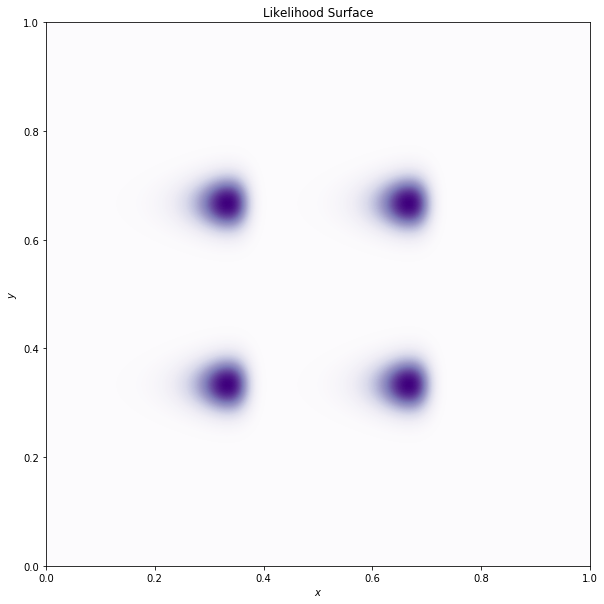

In [14]:
# plot the log-likelihood surface
plt.figure(figsize=(10., 10.))
axes = plt.axes(aspect=1)
xx, yy = np.meshgrid(np.linspace(0., 1., 200),
                     np.linspace(0., 1., 200))
logL = np.array([loglike(np.array([x, y]))
                 for x, y in zip(xx.flatten(), yy.flatten())])
L = np.exp(logL.reshape(xx.shape))
axes.contourf(xx, yy, L, 200, cmap=plt.cm.Purples)
plt.title('Likelihood Surface')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');